# Defensive Asset Allocation with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data


In [128]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

%matplotlib inline
from matplotlib import pyplot as plt

import quantstats

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [130]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05

    # Canaria Assets
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    ]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

In [131]:
# for weekly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [132]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [133]:
def get_momentum(yld_df):
    """
    yiled_df : dataframe with weekly yield of asset classes
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # data set consists of weekly data
            # 52 weeks per year = 12 month per year
            if i > 52 :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                current = yld_df[asset].iloc[i]
                before_1m = yld_df[asset].iloc[i-4]
                before_3m = yld_df[asset].iloc[i-13]
                before_6m = yld_df[asset].iloc[i-26]
                before_12m = yld_df[asset].iloc[i-52]

                momentum.loc[date, asset] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                            + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
            else:
                momentum.loc[date, asset] = 0
            i = i + 1

    # abnormal data processing
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)

    return momentum

def select_sector(yld_df):

    momentum_df = get_momentum(yld_df)

    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2'],
        index=momentum_df.index
    )

    selectable_asset = [
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "QQQ",  # Invesco QQQ trust Nasdaq 100                          1999-03-10
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "GSG",  # iShares S&P GSCI Commodity-Indexed Trust              2006-07-10

    ]

    for date in momentum_df.index:
        emerging_momentum = momentum_df.loc[date,'VWO']
        bnd_momentum = momentum_df.loc[date,'BND']

        short_treasury_momentum = momentum_df.loc[date,'SHY']
        mid_treasury_momentum = momentum_df.loc[date,'IEI']

        sorted_momentum = momentum_df[selectable_asset].loc[date].sort_values(ascending=False)

        if emerging_momentum >= 0 and bnd_momentum >= 0:
            selected_momentum.loc[date,'momentum_1'] = sorted_momentum[0]
            selected_ticker.loc[date,'momentum_1'] = sorted_momentum.index[0]

            selected_momentum.loc[date,'momentum_2'] = sorted_momentum[1]
            selected_ticker.loc[date,'momentum_2'] = sorted_momentum.index[1]

        else:
            selected_momentum.loc[date,'momentum_1'] = short_treasury_momentum
            selected_ticker.loc[date,'momentum_1'] = 'SHY'

            selected_momentum.loc[date,'momentum_2'] = mid_treasury_momentum
            selected_ticker.loc[date,'momentum_2'] = 'IEI'

    return selected_ticker


def sector_momentum(yld_df):
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in mom_ticker_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/2
    mp_table = mp_table.fillna(0)

    return mp_table


In [134]:
mp_table_result = sector_momentum(yield_df)

In [135]:
def trim_data(yld_df, mp_table, benchmark_yield_df):

    yld_df = yld_df.iloc[52 + 1:]
    mp_table = mp_table.iloc[52 + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[52 + 1:]
    return yld_df, mp_table, benchmark_yield_df

yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)

In [136]:
print("frequency of portfolio")
mp_table_result.sum() * 2

frequency of portfolio


IVV      8.0
QQQ      7.0
VEA     10.0
TLT     13.0
TIP      7.0
LQD     12.0
DBC      9.0
RWR     10.0
GSG     10.0
SHY    666.0
IEI    666.0
VWO      0.0
BND      0.0
dtype: float64

In [137]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=sector_momentum, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy = rebal_strategy.iloc[52:]
rebal_strategy

,strategy_return,benchmark_return,IVV,QQQ,VEA,TLT,TIP,LQD,DBC,RWR,GSG,SHY,IEI,VWO,BND,SUM
Date,,,,,,,,,,,,,,,,
2009-01-25,-0.063517,-0.02061,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-02-01,0.040134,-0.009471,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-02-08,-0.001879,-0.010889,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-02-15,0.063699,0.002897,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-02-22,-0.082139,-0.016395,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-06,-0.002726,0.006386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,1.0
2022-02-13,-0.004647,-0.008557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,1.0
2022-02-20,-0.006469,-0.009347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,1.0


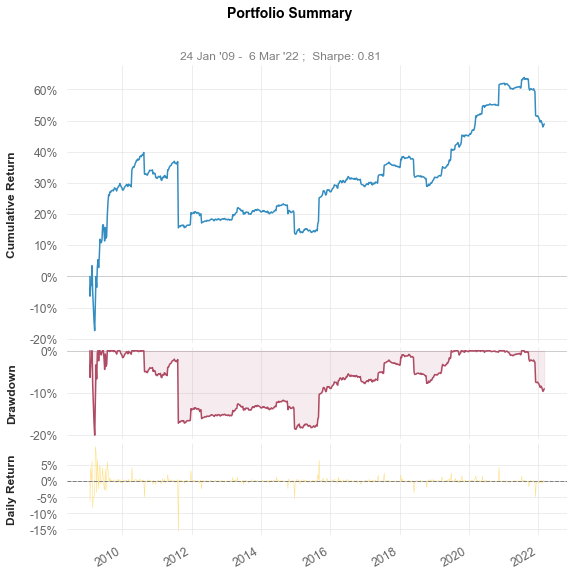

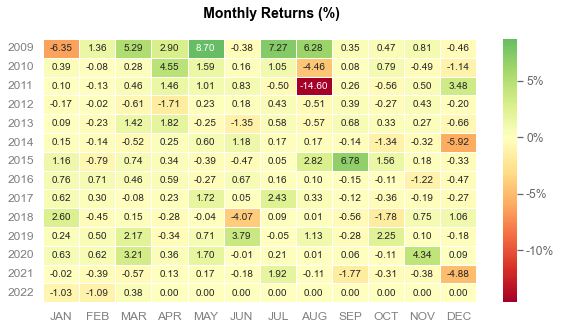

In [138]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

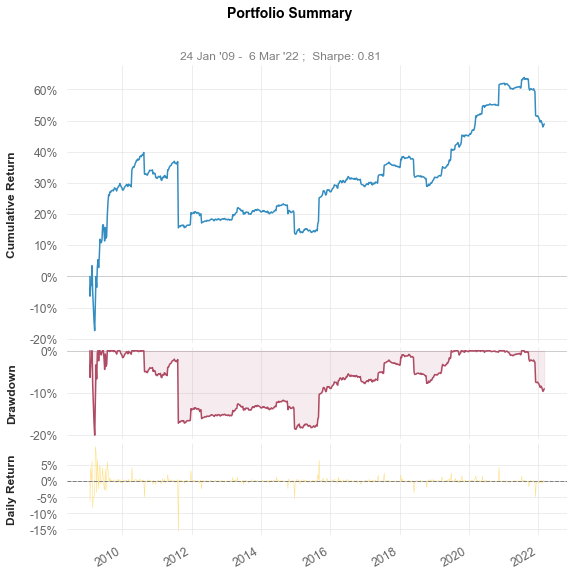

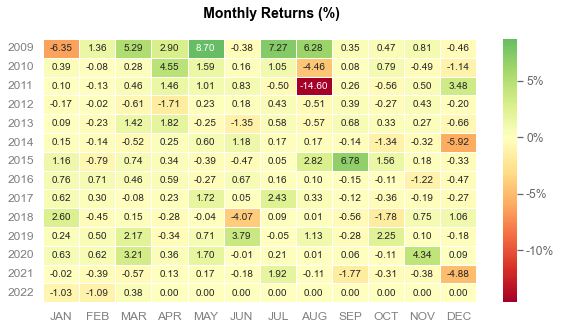

In [139]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-01-25  2009-01-25
End Period                 2022-03-06  2022-03-06
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          48.93%      170.11%
CAGR﹪                     3.08%       7.87%

Sharpe                     0.81        2.48
Smart Sharpe               0.79        2.4
Sortino                    1.15        3.68
Smart Sortino              1.12        3.57
Sortino/√2                 0.82        2.6
Smart Sortino/√2           0.79        2.52
Omega                      1.33        1.33

Max Drawdown               -20.14%     -9.11%
Longest DD Days            3234        483
Volatility (ann.)          20.76%      15.21%
R^2                        0.11        0.11
Calmar                     0.15        0.86
Skew                       -1.24       -0.62
Kurtosis                   46.86       6.8

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-02-22,2009-03-15,2009-04-19,56,-20.137786,-17.219274
2,2010-08-22,2015-01-04,2019-06-30,3234,-18.754766,-18.405100
3,2021-08-15,2022-02-20,2022-03-06,203,-9.698033,-9.438563
4,2009-06-21,2009-06-28,2009-07-26,35,-4.461979,-3.719270
5,2009-04-26,2009-04-26,2009-05-03,7,-2.387703,0.000000


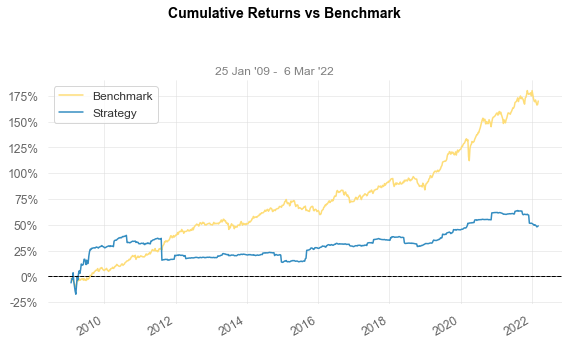

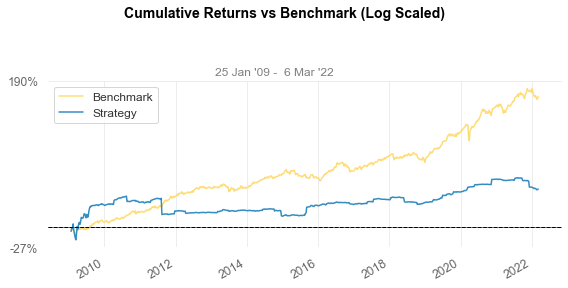

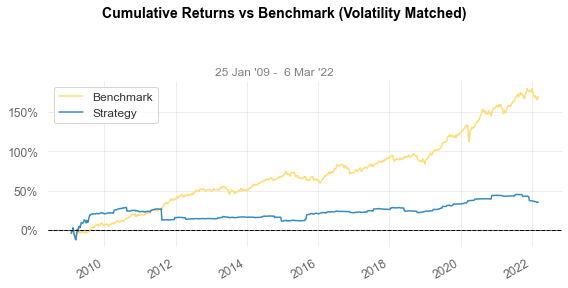

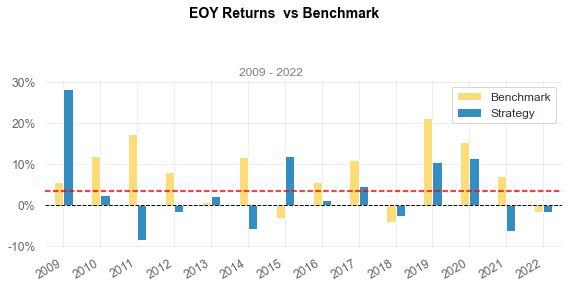

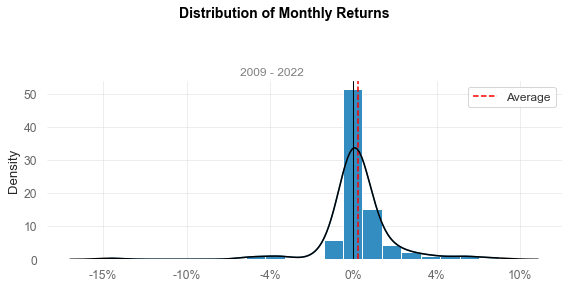

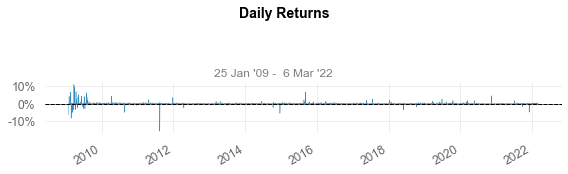

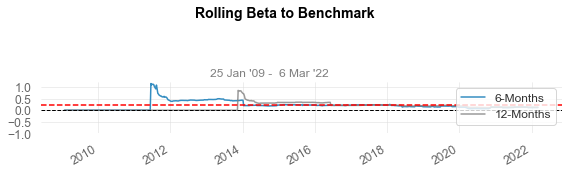

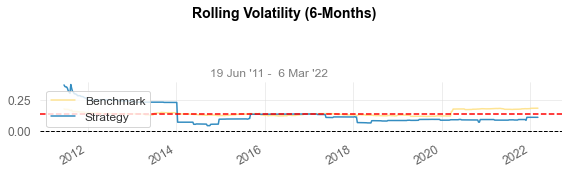

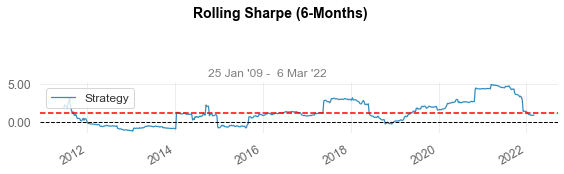

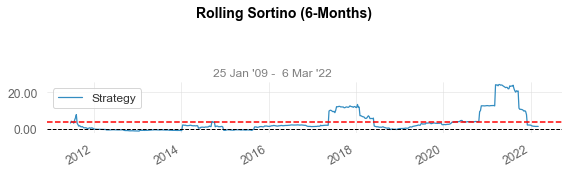

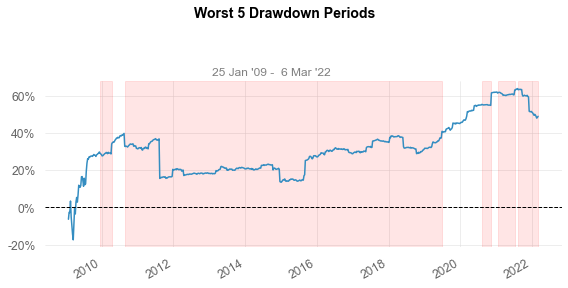

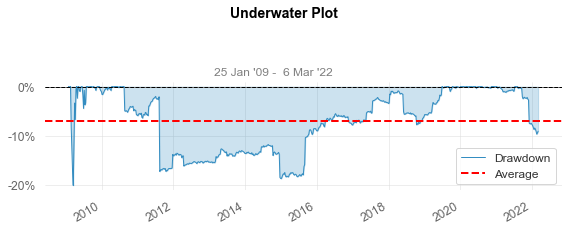

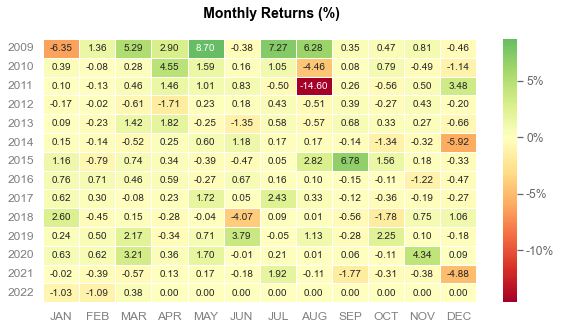

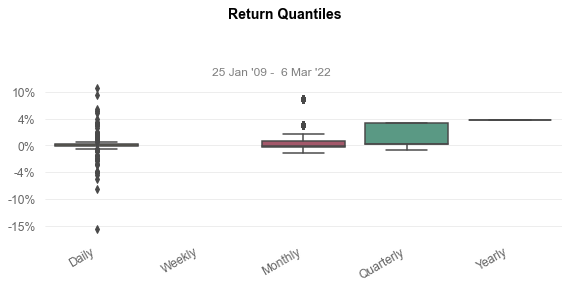

In [140]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)